In [110]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt


auth_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

#### Example list of genres we're interested in:

In [5]:
genre_list = [
    'soundtrack','indie','jazz','pop','electronic','folk','hip-hop','rock','alternative','classical','rap','world',
    'soul','blues','R&B','reggae','ska','dance','country','opera'
]
print(f'We have {len(genre_list)} genres.')

We have 20 genres.


## Get the track/artist/album data

In [6]:
# Start timer
start = timeit.default_timer()

# Set empty lists for each feature
track_name = []
popularity = []
track_id = []
artist_name = []
artist_id = []
artist_genre = []
album_name = []
album_id = []
release_date = []
followers = []

# Loop through the genre list and use each genre as a parameter when running the track-type search 
for genre in genre_list:
    # save track-type search in variable
    track_looped = sp.search(q='genre:'+genre, type='track',limit=3) # set limit to number of songs to grab per genre
    # loop through saved search results, append according to their index/position within the nested levels of dictionaries/lists
    for i, t in enumerate(track_looped['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        artist_id.append(t['artists'][0]['id'])
        album_name.append(t['album']['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        artist_genre.append(genre)

# Using the album names collected from the first search, conduct album-type search to retrieve release date (only found with album search)
for album in album_name:
    album_looped = sp.search(q='album:'+album, type='album',limit=1)
    # similarly, append appropriate metrics found within the nests
    for i, a in enumerate(album_looped['albums']['items']):
        album_id.append(a['id'])
        release_date.append(a['release_date'])

# Lastly, using the artist names collected from first search, conduct artist-type search to retrieve number of followers per artist (only found with artist search)
for name in artist_name: 
    artist_looped = sp.search(q='artist:'+name, type='artist',limit=1)
    for i, n in enumerate(artist_looped['artists']['items']):
        followers.append(n['followers']['total'])

stop = timeit.default_timer()
print(f'This took {stop - start} seconds to complete.')

This took 13.601882899999993 seconds to complete.


#### Checking total tracks gathered:

In [7]:
print(f'Total number of track IDs: {len(track_id)}')

Total number of track IDs: 60


#### Load the lists as a DataFrame:

In [8]:
df_tracks = pd.DataFrame({
    'genre':artist_genre,
    'artist_name':artist_name, 
    'artist_id':artist_id,
    'followers':followers,
    'track_name':track_name, 
    'track_id':track_id,
    'popularity':popularity,
    'album_name':album_name,
    'album_id':album_id,
    'release_date':release_date
})
df_tracks.head()

,genre,artist_name,artist_id,followers,track_name,track_id,popularity,album_name,album_id,release_date
0,soundtrack,Toby Fox,57DlMWmbVIf2ssJ8QBpBau,712621,Fallen Down,1jDMi92a9zNQuPD3uPMkla,77,UNDERTALE Soundtrack,2M2Ae2SvZe3fmzUtlVOV5Z,2015-09-15
1,soundtrack,Michael Giacchino,4kLvhMAuCloLxoP1aVM7Lr,253353,The Batman,1NkI8DtCnjcWVCVLF0gB71,74,The Batman (Original Motion Picture Soundtrack),18nTX27XXEYARGmWMTgD19,2022-02-24
2,soundtrack,Hans Zimmer,0YC192cP3KPCRWx8zr8MfZ,2926117,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP,78,Interstellar (Original Motion Picture Soundtra...,3B61kSKTxlY36cYgzvf3cP,2014-11-18
3,indie,The Walters,027TpXKGwdXP7iwbjUSpV8,325256,I Love You So,4SqWKzw0CbA05TGszDgMlc,96,I Love You So,7ucm85tRsWk6EyVHaYAxe9,2014-11-28
4,indie,Yot Club,6FugQjLquBF4JzATRN70bR,150427,YKWIM?,2vWBUC9djv6BtiGlmKiQaH,88,Bipolar,60jUlxAOAcsiQUEW0XLroT,2019-05-31


#### Checking for track or artist duplicates

In [9]:
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
f'This df_tracks has {grouped[grouped > 1].count()} duplicates to be addressed.'

'This df_tracks has 5 duplicates to be addressed.'

Duplicates will probably occur frequently since its an issue with how Spotify classifies multiple genres per artist and how our provided genre parameters are purposely broad. E.g. Earth, Wind & Fire is classified as Jazz and Soul (among other things), so may appear in our dataset multiple times if the dataset is large enough.

#### Drop duplicates

In [10]:
print(f'We start with a DataFrame with shape {df_tracks.shape}.')

We start with a DataFrame with shape (60, 10).


In [11]:
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

In [12]:
grouped_after_drop = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
print(f'This df_tracks has {grouped_after_drop[grouped_after_drop > 1].count()} duplicates to be addressed.')

This df_tracks has 0 duplicates to be addressed.


In [13]:
print(f'DataFrame has shape {df_tracks.shape} after addressing any duplicates.')

DataFrame has shape (54, 10) after addressing any duplicates.


## Get the audio features per track

In [14]:
# The audio features search has a limit of 100 track IDs that can be submitted per query.
start = timeit.default_timer()

# empty list for rows, define the batchsize as the limit per query, zeroing the None_counter
rows = []
batchsize = 100
None_counter = 0

for i in range(0, len(df_tracks['track_id']), batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter +1
        else:
            rows.append(t)

print(f'Number of tracks where no audio features were available:', None_counter)

stop = timeit.default_timer()
print(f'This took {stop - start} seconds to complete.')

Number of tracks where no audio features were available: 0
This took 0.10311949999999115 seconds to complete.


#### Inspect the audio features dataset

In [15]:
print(f'Number of elements in audio features dataset: {len(rows)}')

Number of elements in audio features dataset: 54


In [16]:
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
df_audio_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.624,0.660,2,-12.779,1,0.0569,0.797,0.786,0.1140,0.8710,110.021,audio_features,1jDMi92a9zNQuPD3uPMkla,spotify:track:1jDMi92a9zNQuPD3uPMkla,https://api.spotify.com/v1/tracks/1jDMi92a9zNQ...,https://api.spotify.com/v1/audio-analysis/1jDM...,57818,3
1,0.209,0.152,10,-16.519,0,0.0324,0.500,0.903,0.1030,0.0482,80.136,audio_features,1NkI8DtCnjcWVCVLF0gB71,spotify:track:1NkI8DtCnjcWVCVLF0gB71,https://api.spotify.com/v1/tracks/1NkI8DtCnjcW...,https://api.spotify.com/v1/audio-analysis/1NkI...,407533,4
2,0.180,0.226,9,-16.457,0,0.0420,0.951,0.982,0.0998,0.0480,94.079,audio_features,6pWgRkpqVfxnj3WuIcJ7WP,spotify:track:6pWgRkpqVfxnj3WuIcJ7WP,https://api.spotify.com/v1/tracks/6pWgRkpqVfxn...,https://api.spotify.com/v1/audio-analysis/6pWg...,126960,4
3,0.575,0.648,10,-4.891,1,0.0358,0.583,0.000,0.1150,0.4660,75.977,audio_features,4SqWKzw0CbA05TGszDgMlc,spotify:track:4SqWKzw0CbA05TGszDgMlc,https://api.spotify.com/v1/tracks/4SqWKzw0CbA0...,https://api.spotify.com/v1/audio-analysis/4SqW...,160240,4
4,0.372,0.537,9,-7.623,1,0.0305,0.937,0.873,0.2870,0.2280,123.735,audio_features,2vWBUC9djv6BtiGlmKiQaH,spotify:track:2vWBUC9djv6BtiGlmKiQaH,https://api.spotify.com/v1/tracks/2vWBUC9djv6B...,https://api.spotify.com/v1/audio-analysis/2vWB...,212750,3


In [17]:
df_audio_features[df_audio_features.duplicated(subset=['id'],keep=False)]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature


In [18]:
df_audio_features.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [19]:
df_tracks.columns

Index(['genre', 'artist_name', 'artist_id', 'followers', 'track_name',
       'track_id', 'popularity', 'album_name', 'album_id', 'release_date'],
      dtype='object')

#### Transform audio features DataFrame

In [20]:
df_audio_features.drop(['track_href','analysis_url','uri','type'], axis=1, inplace=True)
df_audio_features.rename(columns={'id':'track_id'}, inplace=True)

### Generate the dataframes in the format of tables in ERD

In [108]:
df_all = pd.merge(df_tracks, df_audio_features, on='track_id', how='inner')

df_all ['release_date']= pd.to_datetime(df_all.release_date, format='%Y-%m-%d')
df_all ['release_date'] = df_all ['release_date'].dt.strftime('%Y')

df_all = df_all[df_all["release_date"] >= "2010"]
df_all


,genre,artist_name,artist_id,followers,track_name,track_id,popularity,album_name,album_id,release_date,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,soundtrack,Toby Fox,57DlMWmbVIf2ssJ8QBpBau,712621,Fallen Down,1jDMi92a9zNQuPD3uPMkla,77,UNDERTALE Soundtrack,2M2Ae2SvZe3fmzUtlVOV5Z,2015,...,-12.779,1,0.0569,0.79700,0.786000,0.1140,0.8710,110.021,57818,3
1,soundtrack,Michael Giacchino,4kLvhMAuCloLxoP1aVM7Lr,253353,The Batman,1NkI8DtCnjcWVCVLF0gB71,74,The Batman (Original Motion Picture Soundtrack),18nTX27XXEYARGmWMTgD19,2022,...,-16.519,0,0.0324,0.50000,0.903000,0.1030,0.0482,80.136,407533,4
2,soundtrack,Hans Zimmer,0YC192cP3KPCRWx8zr8MfZ,2926117,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP,78,Interstellar (Original Motion Picture Soundtra...,3B61kSKTxlY36cYgzvf3cP,2014,...,-16.457,0,0.0420,0.95100,0.982000,0.0998,0.0480,94.079,126960,4
3,indie,The Walters,027TpXKGwdXP7iwbjUSpV8,325256,I Love You So,4SqWKzw0CbA05TGszDgMlc,96,I Love You So,7ucm85tRsWk6EyVHaYAxe9,2014,...,-4.891,1,0.0358,0.58300,0.000000,0.1150,0.4660,75.977,160240,4
4,indie,Yot Club,6FugQjLquBF4JzATRN70bR,150427,YKWIM?,2vWBUC9djv6BtiGlmKiQaH,88,Bipolar,60jUlxAOAcsiQUEW0XLroT,2019,...,-7.623,1,0.0305,0.93700,0.873000,0.2870,0.2280,123.735,212750,3
8,jazz,Etta James,0iOVhN3tnSvgDbcg25JoJb,1320489,At Last,4Hhv2vrOTy89HFRcjU3QOx,79,At Last!,3arNdjotCvtiiLFfjKngMc,2015,...,-8.631,1,0.0293,0.54700,0.013300,0.3340,0.3280,87.430,179693,3
9,pop,Doja Cat,5cj0lLjcoR7YOSnhnX0Po5,17201187,Woman,6Uj1ctrBOjOas8xZXGqKk4,97,Planet Her,1nAQbHeOWTfQzbOoFrvndW,2021,...,-4.175,0,0.0854,0.08880,0.002940,0.1170,0.8810,107.998,172627,4
10,pop,Doja Cat,5cj0lLjcoR7YOSnhnX0Po5,17201187,Need to Know,3Vi5XqYrmQgOYBajMWSvCi,94,Planet Her,1nAQbHeOWTfQzbOoFrvndW,2021,...,-6.509,1,0.0707,0.30400,0.000000,0.0926,0.1940,130.041,210560,4
11,pop,Dove Cameron,2W8yFh0Ga6Yf3jiayVxwkE,3287212,Boyfriend,59CfNbkERJ3NoTXDvoURjj,96,Boyfriend,4jUfPmvZGiRRJwULbfk1dc,2022,...,-6.543,0,0.0608,0.23200,0.000000,0.1940,0.2320,179.773,153000,3
13,electronic,DJ Snake,540vIaP2JwjQb9dm3aArA4,7733647,U Are My High,3S7A85bAWOd6ltk6r2ANOI,80,U Are My High,0LMzMzG385642dtYwsVLkq,2021,...,-4.761,0,0.0385,0.02210,0.002230,0.1400,0.2130,125.122,180480,4


In [57]:
df_all.shape

(54, 23)

In [23]:
df_all.columns

Index(['genre', 'artist_name', 'artist_id', 'followers', 'track_name',
       'track_id', 'popularity', 'album_name', 'album_id', 'release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [24]:
artist_data = df_all[['artist_name','artist_id','followers']]
album_data = df_all[['album_name','album_id','release_date']]
track_features = df_all[[
    'track_name',
    'track_id',
    'artist_id',
    'album_id',
    'acousticness',
    'danceability',
    'duration_ms',
    'energy',
    'genre',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'popularity',
    'speechiness',
    'tempo',
    'time_signature',
    'valence'
]]

In [25]:
print(f'DataFrames artist_data has shape {artist_data.shape}, album_data has shape {album_data.shape} and track_features has shape {track_features.shape}')

DataFrames artist_data has shape (54, 3), album_data has shape (54, 3) and track_features has shape (54, 19)


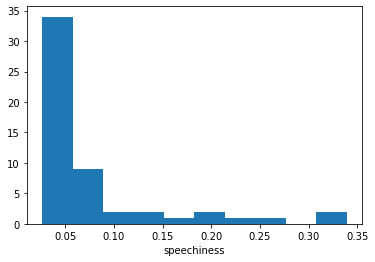

False    50
True      4
Name: speechiness, dtype: int64

In [35]:
#Check Distribution of values across columns 
# speachness
plt.hist(df_all['speechiness'])
plt.xlabel('speechiness')

plt.show()


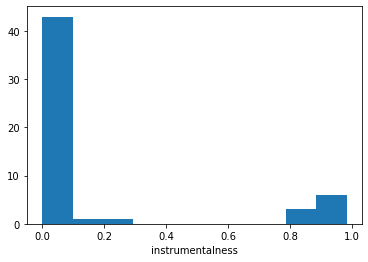

None


In [36]:
#instumentalness 
plt.hist(df_all['instrumentalness'])
plt.xlabel('instrumentalness')
print(plt.show())

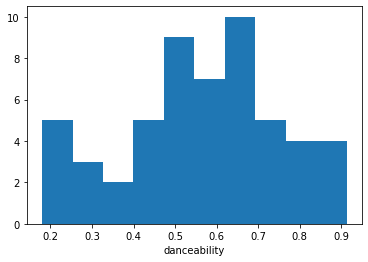

In [37]:
#danceability
plt.hist(df_all['danceability'])
plt.xlabel('danceability')
plt.show()

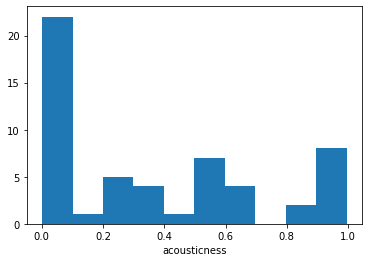

In [39]:
#acousticness
plt.hist(df_all['acousticness'])
plt.xlabel('acousticness')
plt.show()


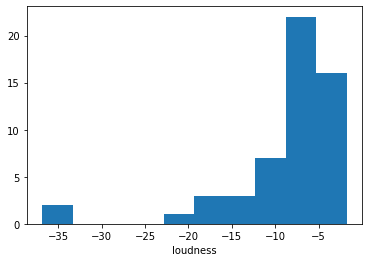

In [40]:
#loudness
plt.hist(df_all['loudness'])
plt.xlabel('loudness')
plt.show()

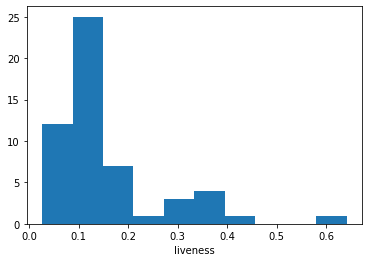

In [42]:
#liveness
plt.hist(df_all['liveness'])
plt.xlabel('liveness')
plt.show()

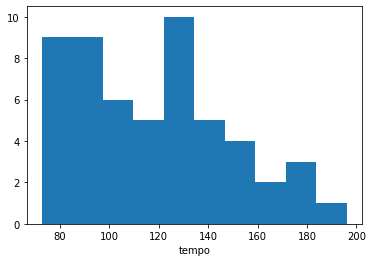

In [43]:
#tempo
plt.hist(df_all['tempo'])
plt.xlabel('tempo')
plt.show()

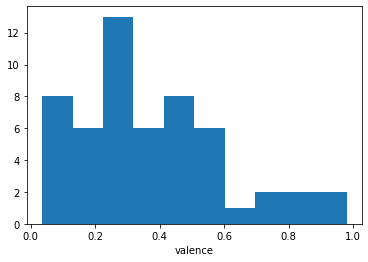

In [44]:
#valence
plt.hist(df_all['valence'])
plt.xlabel('valence')
plt.show()

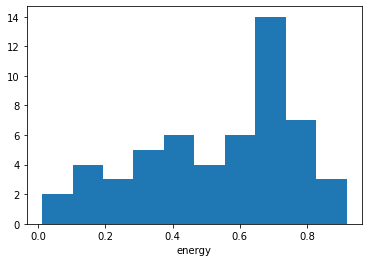

In [45]:
#energy
plt.hist(df_all['energy'])
plt.xlabel('energy')
plt.show()

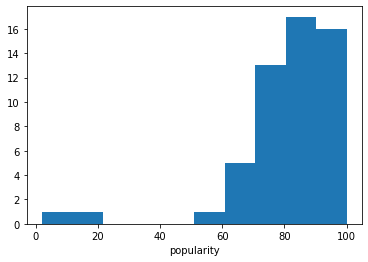

In [46]:
#popularity
plt.hist(df_all['popularity'])
plt.xlabel('popularity')
plt.show()

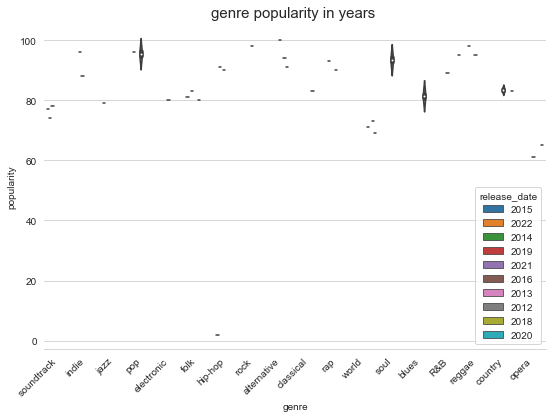

In [109]:
#violin plot
fig, ax = plt.subplots(figsize=(9, 6))

ax = sns.violinplot(x="genre", y="popularity", hue="release_date", data=df_all)

ax.set_title('genre popularity in years ', fontsize=15 );


_ = plt.xticks(rotation=45, ha='right')
sns.despine(left=True)

In [26]:
# # Imports
# from sqlalchemy import create_engine
# import psycopg2 
# from config import db_password

# # Create connection to database (endpoint to be decided)
# db_string = f"postgresql://postgres:{db_password}@{endpoint}"

# # instantiate engine
# engine = create_engine(db_string)

# artist_data.to_sql(name='artist_data', con=engine, if_exists='replace', index=False)
# album_data.to_sql(name='album_data', con=engine, if_exists='replace', index=False)
# track_features.to_sql(name='track_features', con=engine, if_exists='replace', index=False)